In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
import imageio
from pathlib import Path

import embeddings
import clustering
import plotting
from IPython.display import Image
import numpy as np
import pickle

### Set up

In [15]:
DATA_PATH = Path('/media/neuroscout-data/neuroscout/file_data/stimuli/')

In [16]:
dataset_name = 'LTS'

In [17]:
frames = pd.read_csv('/media/neuroscout-data/neuroscout/datasets/raw/ds001545/stimuli/all_frames.csv')
frame_paths = [str(DATA_PATH / Path(p).parts[-1]) for p in frames.path]

### Detect faces

In [ ]:
# Load data
images_50, paths_50 = embeddings.load_detect_crop(frame_paths, minsize=50)

Creating networks and loading parameters


W0804 21:33:09.390650 140531560044352 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:280: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0804 21:33:09.391822 140531560044352 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:281: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0804 21:33:09.394906 140531560044352 deprecation_wrapper.py:119] From /home/alejandro/repos/face_priming/src/facenet/facenet/src/align/detect_face.py:125: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0804 21:33:09.395990 140531560044352 deprecation.py:506] From /home/alejandro/anaconda3/envs/tf_gpu_10/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated a

Loading, cropping, and aligning


In [21]:
len(images_50)

5066

### Get embeddings

In [22]:
embs_50 = embeddings.get_embeddings(images_50)

Model directory: /home/alejandro/repos/face_priming/models/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275


KeyboardInterrupt: 

In [6]:
# Save intermediary
# save_path = Path('/media/neuroscout-data/scratch/face_priming_save/')
# pickle.dump(embs_50, (save_path / 'LTS_embs_50.pkl').open('wb'))
# pickle.dump(paths_50, (save_path / 'LTS_paths_50.pkl').open('wb'))
# pickle.dump(
#     images_50, (save_path / 'LTS_cropped_images_50.pkl').open('wb'), 
#     protocol=4)

### Cluster images

In [8]:
clusters50_05 = clustering.chinese_whispers(paths_50, images_50, embs_50, threshold=0.5)

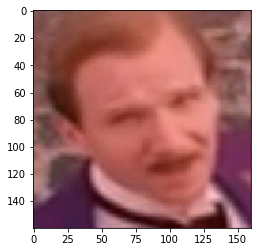

In [28]:
plt.imshow(plotting.standardize(clusters50_05[0][0][1]))

'plots/raiders_cw_t_05_min50.png'

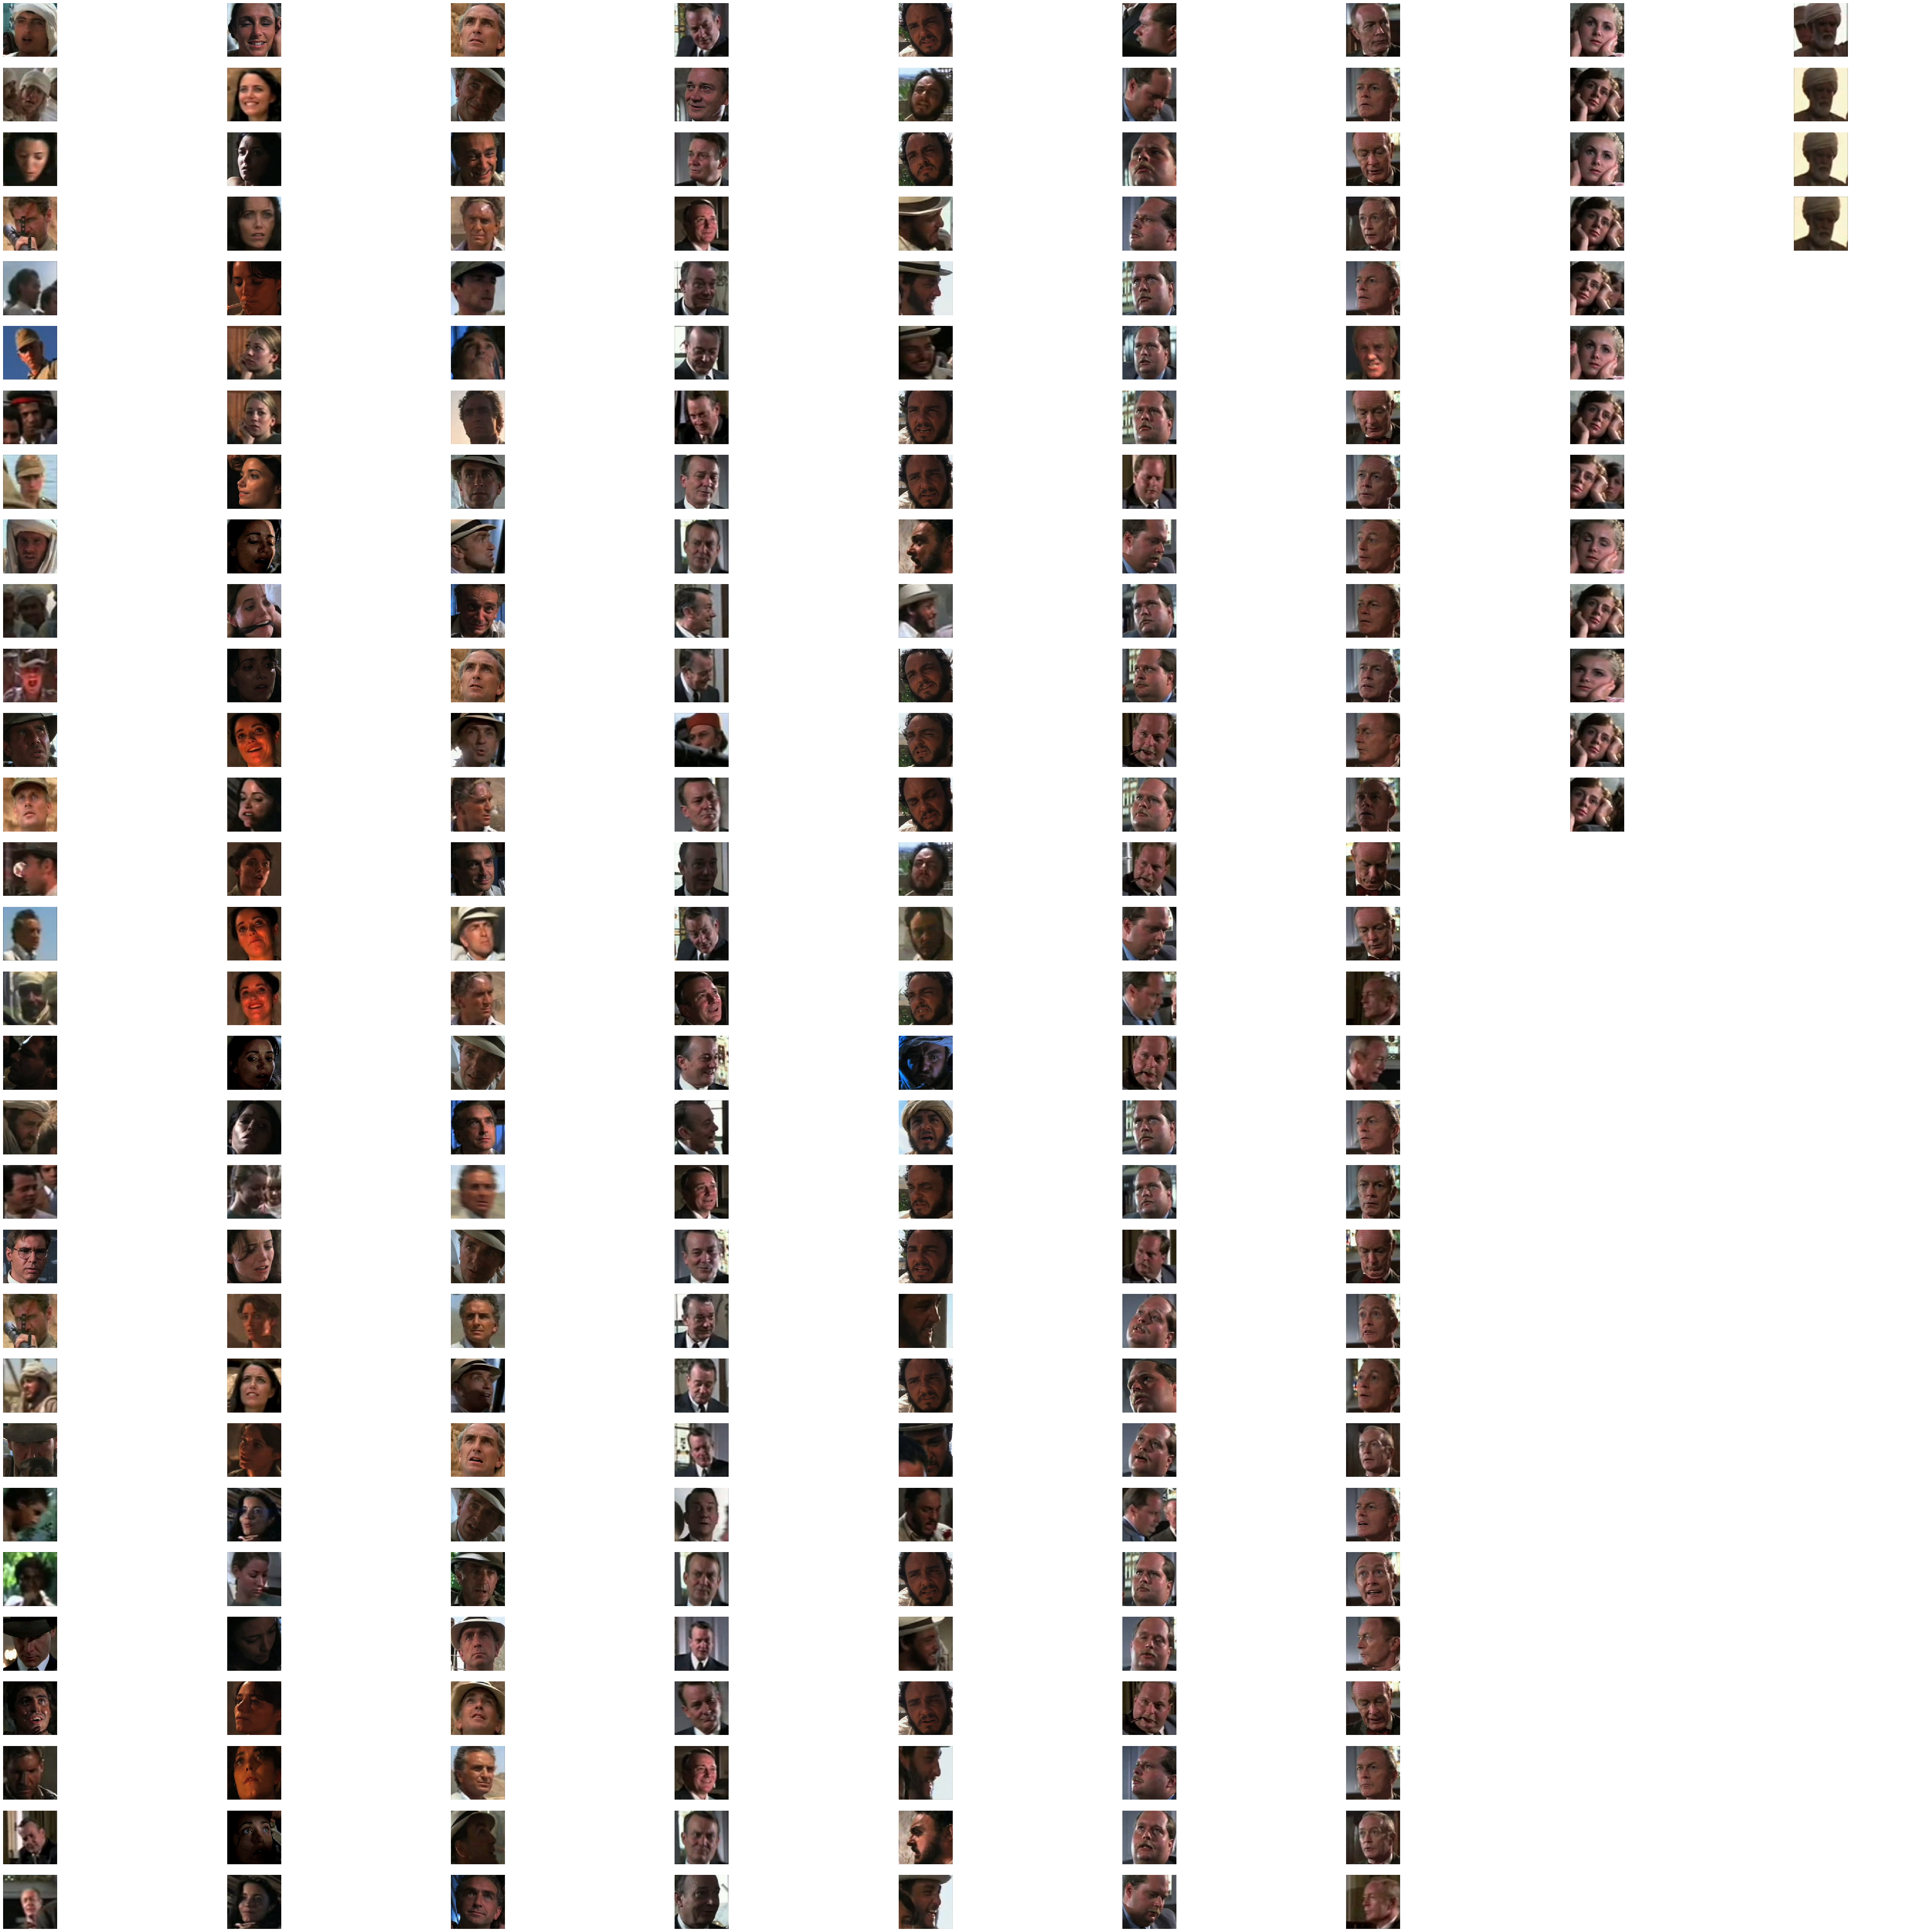

In [11]:
plotting.plot_clusters(clusters50_05, n_sample=30, figsize=(80, 80), 
                       outfile='plots/lts_cw_t_05_min50.png')

In [ ]:
clusters50_59 = clustering.chinese_whispers(paths_50, images_50, embs_50, threshold=0.59)

In [ ]:
plotting.plot_clusters(clusters50_59, n_sample=30, figsize=(80, 80), outfile='plots/lts_cw_t_059_min50.png')

In [ ]:
clusters50_60 = clustering.chinese_whispers(paths_50, images_50, embs_50, threshold=0.60)

In [ ]:
plotting.plot_clusters(clusters50_60, n_sample=30, figsize=(130, 80), outfile='plots/lts_cw_t_060_min50.png')

In [ ]:
clusters50_65 = clustering.chinese_whispers(paths_50, images_50, embs_50, threshold=0.65)

In [ ]:
plotting.plot_clusters(clusters50_65, n_sample=30, figsize=(130, 80), outfile='plots/lts_cw_t_065_min50.png')

### Create predictors

1. Face detection 
2. For chosen solution, predictors for all clusters (or maybe only clusters w/ x number?
3. New face detection (first second face in cluster)
4. Time since last presentation (log transformed)
5. Total onscreen time (log transformed) (for each predictor, then take average across)

#### Fine grained face detection

In [68]:
from importlib import reload
import regressors

In [79]:
reload(regressors)

<module 'regressors' from '/home/alejandro/repos/face_priming/regressors.py'>

In [80]:
output = regressors.prepare_regressors(frames, paths_50, clusters50_59, bad_clusters=[1])

In [81]:
select = output[['run_number', 'onset', 'duration', 'face_count', 'any_faces', 
                'first_time_face', 'log_mean_time_since', 'log_max_time_since', 
                 'log_mean_face_time_cum', 'log_max_face_time_cum']]
event_files = []
for i, x in select.groupby('run_number'):
    df = x.drop(columns=['run_number'])
    fname = f'/home/alejandro/datasets/raw/raiders/stimuli/facenet/facenet_min50_t59_run_{i}.tsv'
    df.to_csv(fname, sep='\t', index=False)
    event_files.append(fname)

### Upload

In [1]:
import pyns

In [144]:
descriptions = {
    "face_count": "Number of faces detected",
    "any_faces": "Binary indicator of face detection",
    "first_time_face": "First time a face is seen",
    "log_mean_time_since": "Time since last seen (mean b/w chars)",
    "log_max_time_since": "Time since last seen (max b/w chars)",
    "log_max_face_time_cum": "Cummulative time face seen (max b/w chars)",
    "log_mean_face_time_cum": "Cummulative time face seen (mean b/w chars)"
}

In [ ]:
dataset_id = 
all_runs = api.runs.get(dataset_id=dataset_id)
### Change this
run_ids = [[r['id'] for r in all_runs if r['number'] == run_number] for run_number in set([a['number'] for a in all_runs])]

In [ ]:
api.predictors.create_collection(
    'lts_facenet_cw_min50_t59', dataset_id, run_ids, event_files, descriptions)